# Introduction - Map-to-Map Change Detection

Change detection is a *hot* topic within the Earth Observation (EO) community, particular since the release of the landsat archive and more recently the availablity of the  ESA Sentinel-1 and 2 data.

There are several approaches to change detection and these can be categorised as:

- Map-to-Map
- Image-to-Image
- Map-to-Image
- Dense Timeseries

These approaches have different advances and disadvantages and this tutorial will demonstrate the implementation of a method for each type.

## What is Map-to-Map Change?

Map-to-Map change detections processes compare to classified maps and where they differ a change has occurred. These approaches can be very **sensitive to mis-classification** in one or both the classification. As you probably already know, classification results, if very good ones (i.e., accuracies > 90 %) still have errors and these are often different between two or more classifications. Therefore, false changes can easily be identified. However, the two classifications can be derived using any method, using any data you like as long as they using **the sample class definitions**, or from data of different seasons. We can therefore say that this approach is **input EO data invariant**.

## What are the steps:

This is quite a simple method, basically we just need to undertake another classification but this time use the 2018 image as the input... Once the classification of the 2018 input image is complete then we can compare the two classification to undertake the change detection. 


# 1. Define Imports

In [1]:
import os
import shutil

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rsgislib
import rsgislib.classification
import rsgislib.imagecalc
import rsgislib.imageutils
import rsgislib.rastergis

# Imports for data visualisation
import rsgislib.tools.plotting
import rsgislib.vectorutils.createrasters
from rsgislib.classification import ClassInfoObj, ClassVecSamplesInfoObj, classxgboost
from rsgislib.imageutils import ImageBandInfo

/Users/pete/miniforge3/envs/osgeo-env-v2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 2. Define Input Data and Directories

In [2]:
out_dir = "2018_cls"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

baseline_dir = "baseline_cls"
if not os.path.exists(baseline_dir):
    os.mkdir(baseline_dir)

map_to_map_chg_dir = "map_to_map_chg"
if not os.path.exists(map_to_map_chg_dir):
    os.mkdir(map_to_map_chg_dir)

tmp_dir = "tmp"
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)

# File path to the input Landsat 8 image from 2018.
input_img = (
    "../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

# Note the Landsat 8 image has an extra image bands over the older Landsat 5 sensor.
imgs_info = []
imgs_info.append(
    ImageBandInfo(file_name=input_img, name="ls18", bands=[1, 2, 3, 4, 5, 6, 7])
)

# 3. Define Training Samples

You need to make sure that the output pixel values (i.e., the `id`) is the same as the baseline classification otherwise when you come to compare the classification is might be confusing and difficult.

In [3]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
class_vec_sample_info.append(
    ClassVecSamplesInfoObj(
        id=1,
        class_name="mangroves",
        vec_file="../data/chg_data/training/2018/mangroves.geojson",
        vec_lyr="mangroves",
        file_h5="2018_cls/mangrove_cls_samples.h5",
    )
)

# Define the file name of the samples HDF5 file, which will be created
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="other_terrestrial",
        vec_file="../data/chg_data/training/2018/other_terrestrial.geojson",
        vec_lyr="other_terrestrial",
        file_h5="2018_cls/other_terrestrial_cls_samples.h5",
    )
)

# Define the file name of the samples HDF5 file, which will be created
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="water",
        vec_file="../data/chg_data/training/2018/water.geojson",
        vec_lyr="water",
        file_h5="2018_cls/water_cls_samples.h5",
    )
)

# 4. Extract Training Data

In [4]:
cls_smpls_info = rsgislib.classification.get_class_training_data(
    imgs_info, class_vec_sample_info, tmp_dir, ref_img=input_img
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Running Rasterise now...
Get Image Min and Max.

Creating output image using input image
Running Rasterise now...Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.




# 5. Define Class Colours

In [5]:
cls_smpls_info["mangroves"].red = 0
cls_smpls_info["mangroves"].green = 255
cls_smpls_info["mangroves"].blue = 0

cls_smpls_info["other_terrestrial"].red = 180
cls_smpls_info["other_terrestrial"].green = 180
cls_smpls_info["other_terrestrial"].blue = 180

cls_smpls_info["water"].red = 0
cls_smpls_info["water"].green = 0
cls_smpls_info["water"].blue = 255

# 6. Number of Samples

Check the number of samples there are per class to help define the number of training, testing and validation samples.

In [6]:
for cls_name in cls_smpls_info:
    smpls_h5_file = cls_smpls_info[cls_name].file_h5
    n_smpls = rsgislib.classification.get_num_samples(smpls_h5_file)
    print(f"{cls_name}: {n_smpls}")

mangroves: 59092
other_terrestrial: 87954
water: 263511


# 7. Define Testing, Validation and Training Samples

In [7]:
# Get a ClassInfoObj dict specifying paths for training, testing and validation
# datasets.
cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, out_dir
)

# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info,
    cls_smpls_fnl_info,
    10000,
    10000,
    35000,
    datatype=rsgislib.TYPE_16UINT,
)

0=1: (Train:2018_cls/mangrove_cls_samples_train.h5, Test:2018_cls/mangrove_cls_samples_test.h5, Valid:2018_cls/mangrove_cls_samples_valid.h5), (0, 255, 0)
1=2: (Train:2018_cls/other_terrestrial_cls_samples_train.h5, Test:2018_cls/other_terrestrial_cls_samples_test.h5, Valid:2018_cls/other_terrestrial_cls_samples_valid.h5), (180, 180, 180)
2=3: (Train:2018_cls/water_cls_samples_train.h5, Test:2018_cls/water_cls_samples_test.h5, Valid:2018_cls/water_cls_samples_valid.h5), (0, 0, 255)


# 8. Define Classification Mask

Mangroves have a unique habitat being close to the coastline with a low elevation. It is therefore no appropriate to look to classify mangroves in other locations. In this case we will use a mangrove habitat mask similar to that used as part of the global mangrove watch study (Bunting et al., 2018). 


## 8.1 Rasterise Mangrove Habitat Mask

In [8]:
vec_file = "../data/chg_data/mangrove_habitat.geojson"
vec_lyr = "mangrove_habitat"

mng_hab_msk_img = os.path.join(out_dir, "mangrove_habitat.kea")

rsgislib.vectorutils.createrasters.rasterise_vec_lyr(
    vec_file, vec_lyr, input_img, mng_hab_msk_img, gdalformat="KEA", burn_val=1
)

Creating output image using input image

Running Rasterise now...
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 8.2 Create Landsat Valid Mask

We need to check which pixels are valid within the landsat image so only those with image pixels values are being used.


In [9]:
vld_pxl_msk_img = os.path.join(out_dir, "LS8_20180608_vmsk.kea")

# Calculate the valid mask
rsgislib.imageutils.gen_valid_mask(
    input_img, vld_pxl_msk_img, gdalformat="KEA", no_data_val=0.0
)

# Populate with stats and pyramids - note it is a binary mask
# so a thematic datasets and therefore the rastergis function
# is used.
rsgislib.rastergis.pop_rat_img_stats(
    vld_pxl_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

0) ../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 8.3 Merge Habitat and Valid Pixel Masks

In [10]:
mng_scn_hab_msk_img = os.path.join(out_dir, "LS8_20180608_vmsk_mng_hab.kea")

# Create Mask for pixels which are valid and within the mangrove habitat mask.
band_defns = list()
band_defns.append(rsgislib.imagecalc.BandDefn("vld", vld_pxl_msk_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("hab", mng_hab_msk_img, 1))
rsgislib.imagecalc.band_math(
    mng_scn_hab_msk_img,
    "(vld==1)&&(hab==1)?1:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)

# Populate the output binary mask with stats and pyramids.
rsgislib.rastergis.pop_rat_img_stats(
    mng_scn_hab_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld' is band 1
Image: 2018_cls/mangrove_habitat.kea
	 Variable 'hab' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 8.4 Visualise Mask

Image Data Size: 1281 x 3659
Image Data Size: 1281 x 3659


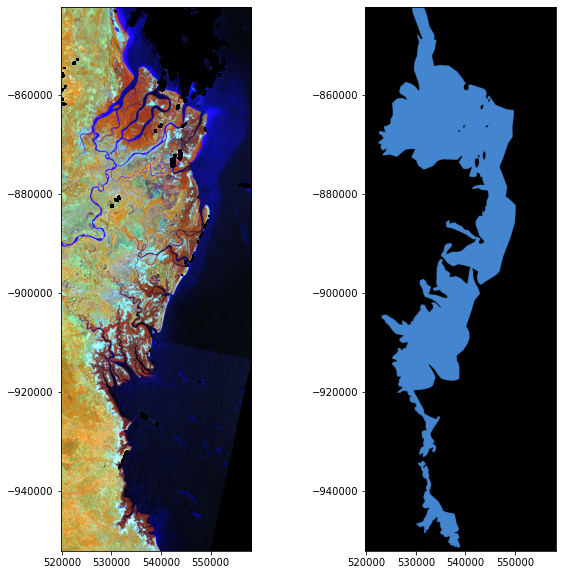

In [11]:
# Visualise with bands 5 (NIR), 6 (SWIR1) and 4 (Red)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[5, 6, 4]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(mng_scn_hab_msk_img)

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_msk_data, extent=img_msk_coords)

# 9. Train Classifier

In [12]:
# Train the classifier
out_mdl_file = os.path.join(out_dir, "cls_xgb_mdl.h5")
classxgboost.train_opt_xgboost_multiclass_classifier(out_mdl_file, cls_smpls_fnl_info)

Reading Class mangroves Training
Reading Class mangroves Validation
Reading Class mangroves Testing
Reading Class other_terrestrial Training
Reading Class other_terrestrial Validation
Reading Class other_terrestrial Testing
Reading Class water Training
Reading Class water Validation
Reading Class water Testing
Finished Reading Data

Next set of params..... {'eta': 0.5376317102202665, 'gamma': 84, 'max_depth': 17, 'min_child_weight': 9, 'max_delta_step': 6, 'subsample': 0.6921908536463499, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 3}
num_boost_round = 31.

AccScore..... 0.9867593512082092 .....iter.....

Next set of params..... {'eta': 0.060474549812524446, 'gamma': 27, 'max_depth': 11, 'min_child_weight': 8, 'max_delta_step': 5, 'subsample': 0.696392398050415, 'nthread': 1, 'eval_metric': 'merror', 'objective': 'multi:softmax', 'num_class': 3}
num_boost_round = 84.

AccScore..... 0.9900695134061569 .....iter.....

Next set of params..... {'eta': 

# 10. Apply Classifier

In [13]:
# Apply the classifier to the image
cls_2018_img = os.path.join(out_dir, "class_2018_img.kea")
classxgboost.apply_xgboost_multiclass_classifier(
    cls_smpls_fnl_info,
    out_mdl_file,
    mng_scn_hab_msk_img,
    1,
    imgs_info,
    cls_2018_img,
    "KEA",
)

Applying the Classifier


  0%|          | 0/100 [00:00<?, ?it/s]

Completed Classification
Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.

Apply Colour to class 'mangroves'
Apply Colour to class 'other_terrestrial'
Apply Colour to class 'water'


# 11. Visualise Classification Result

Image Data Size: 1281 x 3659
Image Data Size: 1281 x 3659


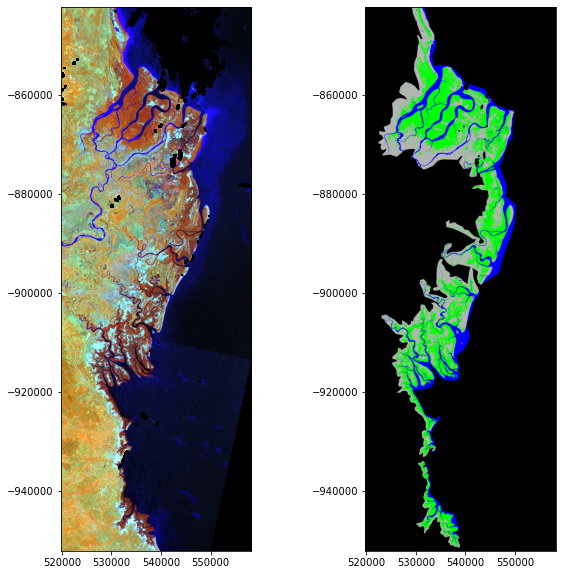

In [14]:
# Visualise with bands 5 (NIR), 6 (SWIR1) and 4 (Red)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[5, 6, 4]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(cls_2018_img)

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_msk_data, extent=img_msk_coords)

# 12. Visualise Subset

Image Data Size: 900 x 767
Image Data Size: 900 x 767


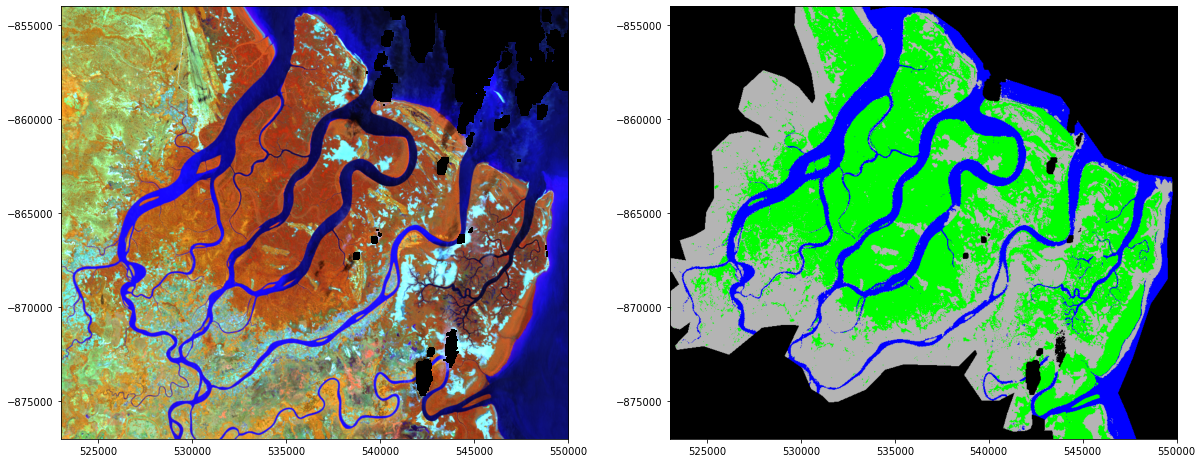

In [15]:
sub_bbox = [523000, 550000, -877000, -854000]

# Visualise with bands 5 (NIR), 6 (SWIR1) and 4 (Red)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[5, 6, 4], bbox=sub_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    cls_2018_img, bbox=sub_bbox
)

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_msk_data, extent=img_msk_coords)

# 13. Compare Classifications

## 13.1 Define the 1997 (baseline) file paths

In [16]:
# File path to the 1997 classification
cls_1997_img = os.path.join(baseline_dir, "base_1997_class_img.kea")

# File path to the input Landsat 5 image from 1997.
input_97_img = (
    "../data/chg_data/LS5TM_19970716_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

# File path to the Landsat 5 valid data mask from 1997
vld_97_img = os.path.join(baseline_dir, "LS5TM_19970716_vmsk.kea")

## 13.2 Visualise Classifications

Image Data Size: 900 x 767
Image Data Size: 900 x 767
Image Data Size: 900 x 767
Image Data Size: 900 x 767


Text(0.5, 1.0, 'Classification 2018')

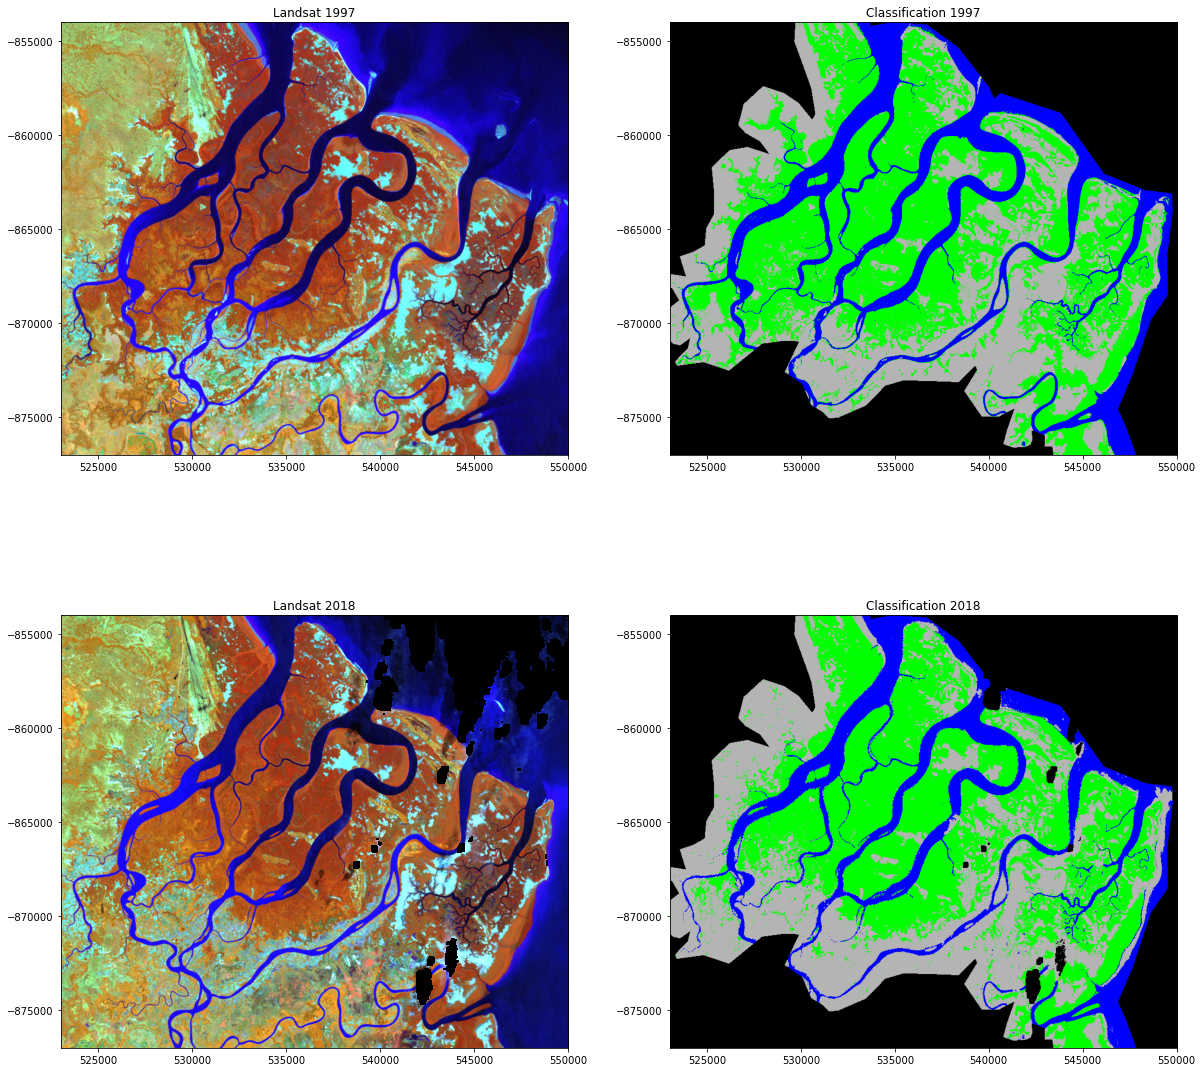

In [17]:
sub_bbox = [523000, 550000, -877000, -854000]

##### Start 1997 ######
# Visualise with bands 4 (NIR), 5 (SWIR1) and 3 (Red)
img_1997_data, img_1997_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_97_img, bands=[4, 5, 3], bbox=sub_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_1997_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_1997_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_1997_msk_data,
    img_1997_msk_coords,
    lgd_1997_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    cls_1997_img, bbox=sub_bbox
)
##### End 1997 ######


##### Start 2018 ######
# Visualise with bands 5 (NIR), 6 (SWIR1) and 4 (Red)
img_2018_data, img_2018_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[5, 6, 4], bbox=sub_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_2018_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(
    img_2018_data, no_data_val=0.0
)


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_2018_msk_data,
    img_2018_msk_coords,
    lgd_2018_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    cls_2018_img, bbox=sub_bbox
)
##### End 2018 ######


# Create the matplotlib figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_1997_data_strch, extent=img_1997_coords)
ax1.set_title("Landsat 1997")

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_1997_msk_data, extent=img_1997_msk_coords)
ax2.set_title("Classification 1997")

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax3.imshow(img_2018_data_strch, extent=img_2018_coords)
ax3.set_title("Landsat 2018")

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax4.imshow(img_2018_msk_data, extent=img_2018_msk_coords)
ax4.set_title("Classification 2018")

# 14. Fill 2018 Gaps

There are some gaps in the 2018 classifications due to cloud cover. In this case, we will fill the 2018 using the result from the 1997 classification. Clearly for these regions there will be no change identified as the classification will be the same.


## 14.1 Using `band_math` to perform fill

In [18]:
# Define output image path
cls_2018_filled_img = os.path.join(out_dir, "class_2018_fill_img.kea")

# Define the input image bands
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("vld_97_msk", vld_97_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("vld_18_msk", vld_pxl_msk_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_2018", cls_2018_img, 1))

# Expression to perform fill
exp = """(vld_18_msk==1)&&(vld_97_msk==1)?cls_2018:
         (vld_18_msk==0)&&(vld_97_msk==1)?cls_1997:0"""

# Run band_math
rsgislib.imagecalc.band_math(
    cls_2018_filled_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)

# Populate stats and pyramids
rsgislib.rastergis.pop_rat_img_stats(
    cls_2018_filled_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld_18_msk' is band 1
Image: 2018_cls/class_2018_img.kea
	 Variable 'cls_2018' is band 1
Image: baseline_cls/LS5TM_19970716_vmsk.kea
	 Variable 'vld_97_msk' is band 1
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 14.2 Add Classification Colours and Names

In [19]:
class_info_dict = dict()
class_info_dict[1] = {"classname": "mangroves", "red": 0, "green": 255, "blue": 0}
class_info_dict[2] = {
    "classname": "other_terrestrial",
    "red": 180,
    "green": 180,
    "blue": 180,
}
class_info_dict[3] = {"classname": "water", "red": 0, "green": 0, "blue": 255}

rsgislib.rastergis.set_class_names_colours(
    cls_2018_filled_img, "class_names", class_info_dict
)

# 15. Perform Change Map

## 15.1 Use `band_math` to calculate change

In [20]:
# Define output image path
chng_map_img = os.path.join(map_to_map_chg_dir, "chng_map_1997_2018_img.kea")

# Define the input image bands
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_2018", cls_2018_filled_img, 1))

# Expression to define change classes
exp = """(cls_1997==1)&&(cls_2018==1)?11:
         (cls_1997==1)&&(cls_2018==2)?12:
         (cls_1997==1)&&(cls_2018==3)?13:
         (cls_1997==2)&&(cls_2018==1)?21:
         (cls_1997==2)&&(cls_2018==2)?22:
         (cls_1997==2)&&(cls_2018==3)?23:
         (cls_1997==3)&&(cls_2018==1)?31:
         (cls_1997==3)&&(cls_2018==2)?32:
         (cls_1997==3)&&(cls_2018==3)?33:0
      """

# Run band_math
rsgislib.imagecalc.band_math(chng_map_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns)

# Populate stats and pyramids
rsgislib.rastergis.pop_rat_img_stats(
    chng_map_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: 2018_cls/class_2018_fill_img.kea
	 Variable 'cls_2018' is band 1
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 15.2 Define Change Colours and Names

In [21]:
class_info_dict = dict()
class_info_dict[11] = {
    "classname": "Mangrove_Mangrove",
    "red": 25,
    "green": 200,
    "blue": 25,
}
class_info_dict[12] = {
    "classname": "Mangrove_Terrestrial",
    "red": 200,
    "green": 100,
    "blue": 25,
}
class_info_dict[13] = {
    "classname": "Mangrove_Water",
    "red": 200,
    "green": 25,
    "blue": 200,
}
class_info_dict[21] = {
    "classname": "Terrestrial_Mangrove",
    "red": 125,
    "green": 100,
    "blue": 125,
}
class_info_dict[22] = {
    "classname": "Terrestrial_Terrestrial",
    "red": 125,
    "green": 125,
    "blue": 125,
}
class_info_dict[23] = {
    "classname": "Terrestrial_Water",
    "red": 125,
    "green": 125,
    "blue": 100,
}
class_info_dict[31] = {
    "classname": "Water_Mangrove",
    "red": 25,
    "green": 255,
    "blue": 200,
}
class_info_dict[32] = {
    "classname": "Water_Terrestrial",
    "red": 62,
    "green": 62,
    "blue": 200,
}
class_info_dict[33] = {
    "classname": "Water_Water",
    "red": 25, 
    "green": 25,      
    "blue": 200
}

rsgislib.rastergis.set_class_names_colours(chng_map_img, "class_names", class_info_dict)

## 15.3 Visualise Change Map

Image Data Size: 900 x 767


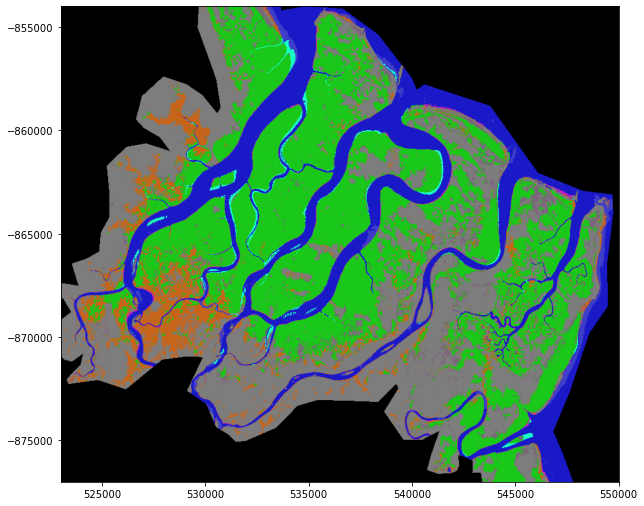

In [22]:
sub_bbox = [523000, 550000, -877000, -854000]

# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    chng_map_img, bbox=sub_bbox
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_msk_data, extent=img_msk_coords)